In [120]:
# Denoising demonstration
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision.transforms.functional import gaussian_blur
import numpy as np
from random import randint
from torch import fft

device = torch.device('cuda:0') # use the first GPU on this system
#device = torch.device('cuda:1') # use the second GPU on this system

In [293]:
dataset_train

tensor([5, 0, 4,  ..., 5, 6, 8])

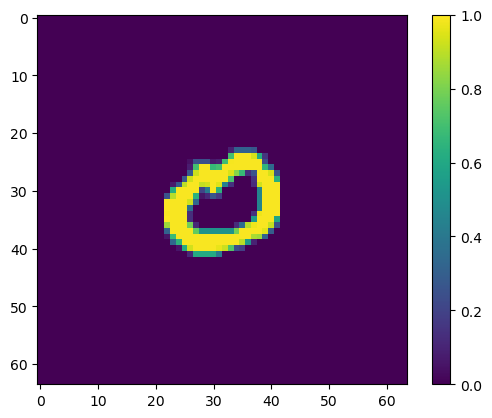

In [281]:
batch_size=64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((18,18,18,18))])
dataset_train = datasets.MNIST(root='data',train=True,download=True,transform=transform)
dataset_val = datasets.MNIST(root='data',train=False,download=True,transform=transform)

dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size, shuffle=False)

img = next(iter(dataloader_train))[0][1].squeeze()
plt.imshow(img)
plt.colorbar()
plt.show()

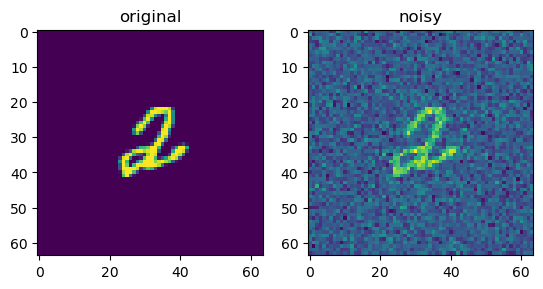

In [123]:
## define a noise process
# TODO: finish refactoring into a function
class ForwardModel( nn.Module ):
    def __init__(self, sigma=0.2):
        super().__init__()

        self.sigma = sigma

    def forward(self, x):
        noise = torch.randn_like(x)
        y = x + self.sigma * noise

        return y

x = next(iter(dataloader_train))[0] # get a batch of images
forwardModel = ForwardModel(0.2)
y = forwardModel(x)
plt.subplot(121)
plt.imshow(x[0].squeeze())
plt.title('original')
plt.subplot(122)
plt.imshow(y[0].squeeze())
plt.title('noisy')
plt.show()


In [91]:
# CNN neural network
class CNN( nn.Module ):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,1,kernel_size=3,padding=1) )

        # initialize
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                nn.init.constant_(m.bias,0)
    

    def forward(self, x):
        return(self.net(x))
    
net = CNN()
net = net.to(device)


In [261]:
# define a simple u-net with batchnorm
class UNet( nn.Module ):
    def __init__(self):
        super().__init__()
        
        self.downconv1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))
        self.downconv2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))
        self.downconv3 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))
        self.downconv4 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))

        self.upconv1 = nn.Sequential(
                    nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                    nn.BatchNorm2d(32) )
        self.upconv2 = nn.Sequential(
                    nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                    nn.BatchNorm2d(32) )
        self.upconv3 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                        nn.BatchNorm2d(32) )
        self.upconv4 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                        nn.BatchNorm2d(32) )

        self.outconv = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 3, padding=1)

    def forward(self, x):
        featdown1 = F.leaky_relu(self.downconv1(x))
        featdown2 = F.leaky_relu(self.downconv2(F.max_pool2d(featdown1,2)))
        featdown3 = F.leaky_relu(self.downconv3(F.max_pool2d(featdown2,2)))
        featdown4 = F.leaky_relu(self.downconv4(F.max_pool2d(featdown3,2)))

        featup1 = F.leaky_relu(self.upconv1(F.max_pool2d(featdown4,2)))
        skip1 = torch.cat((featdown4, featup1),1)
        featup2 = F.leaky_relu(self.upconv2(skip1))
        skip2 = torch.cat((featdown3, featup2),1)
        featup3 = F.leaky_relu(self.upconv3(skip2))
        skip3 = torch.cat((featdown2, featup3),1)
        featup4 = F.leaky_relu(self.upconv4(skip3))
        skip4 = torch.cat((featdown1, featup4),1)
        out = self.outconv(skip4)
        
        return out
        
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.)

net = UNet().to(device)
net.apply(init_weights)

UNet(
  (downconv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downconv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downconv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downconv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upconv1): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

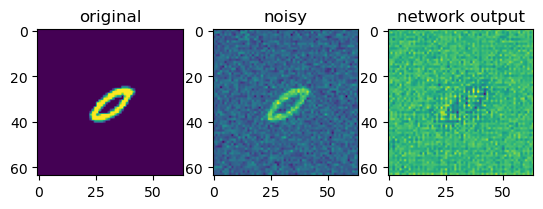

In [128]:
# test run a noisy image through the network
x = next(iter(dataloader_train))[0] # get a batch of images
forwardModel = ForwardModel(0.2)
y = forwardModel(x)
with torch.no_grad():
    xhat = net(y.to(device)) # run through network

plt.subplot(131)
plt.imshow(x[0].squeeze())
plt.title('original')
plt.subplot(132)
plt.imshow(y[0].squeeze())
plt.title('noisy')
plt.subplot(133)
plt.imshow(xhat[0].cpu().squeeze())
plt.title('network output')
plt.show()


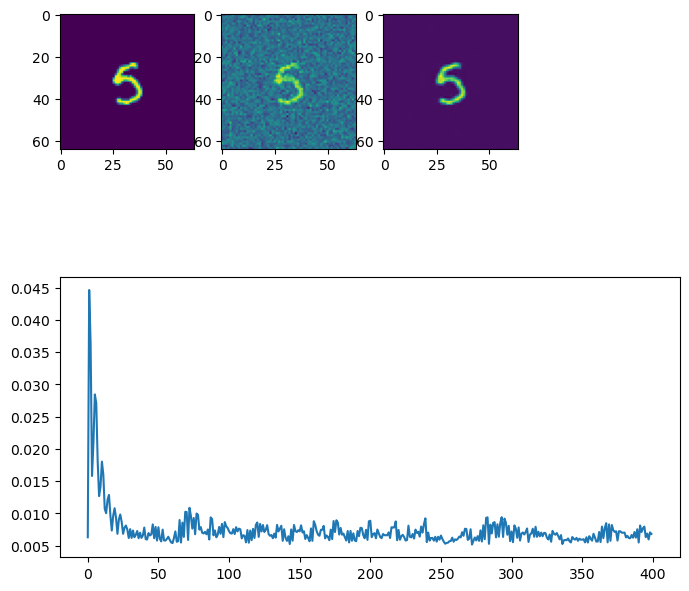

KeyboardInterrupt: 

In [297]:
# supervised training
#optimizer = torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

loss_train_vec = []

# training loop
n_epochs = 10
i_iter = 0
for epoch in range(n_epochs):
    for data, label in dataloader_train:
    
        x = data.to(device)
        y = forwardModel(x)
        xhat = net(y)

        # compare recovered image with measurement
        loss = loss_fn(xhat,x)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
    
        loss_train_vec += [loss.item()]
        i_iter += 1
    
        # plot training/validation loss curves
        if i_iter % 200 == 0:
            clear_output(wait=True)
            plt.figure(figsize=[8,8])
            plt.subplot(241)
            plt.imshow(x[0].cpu().squeeze())
            plt.subplot(242)
            plt.imshow(y[0].cpu().squeeze())
            plt.subplot(243)
            plt.imshow(xhat[0].detach().cpu().squeeze())
            plt.subplot(212)
            plt.plot(loss_train_vec)
            plt.show()

In [295]:
200%200

0

In [269]:
len(dataset_train)

60000

# Uncertainty Estimation

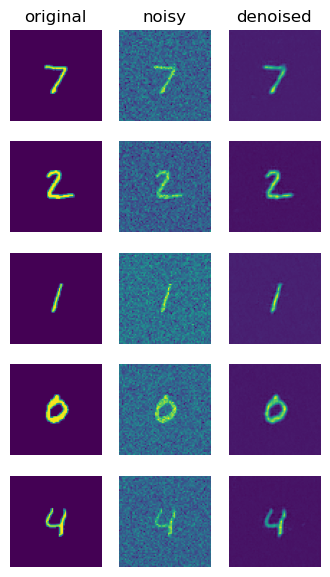

In [132]:
# render a panel of images
x = next(iter(dataloader_val))[0] # get a batch of images
forwardModel = ForwardModel(0.2)
y = forwardModel(x)
with torch.no_grad():
    xhat = net(y.to(device))

plt.figure(figsize=[4,7])
for ind in range(5):
    plt.subplot(5,3,ind*3+1)
    plt.imshow(x[ind].squeeze())
    plt.axis('off')
    if ind==0:
        plt.title('original')
    plt.subplot(5,3,ind*3+2)
    plt.imshow(y[ind].squeeze())
    plt.axis('off')
    if ind==0:
        plt.title('noisy')
    plt.subplot(5,3,ind*3+3)
    plt.imshow(xhat[ind].cpu().squeeze())
    plt.axis('off')
    if ind==0:
        plt.title('denoised')
plt.show()

# Compare against Wiener filter

In [228]:
# define functions for comparison metrics, assuming a single image at a time
from skimage.metrics import structural_similarity
def MSE(x, xhat):
    return np.mean((x-xhat)**2)

def MAE(x, xhat):
    return np.mean(np.abs(x-xhat))

def Pearson(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)

    return np.sum( (x-xbar)*(y-ybar) ) / (np.sqrt(np.sum((x-xbar)**2))*np.sqrt(np.sum((y-ybar)**2)))

def PSNR(x, xhat):
    # note, this assumes images were normalized to a 0-1 range, and will need to change
    # for images normalized to a 0-255 range
    maxPossibleVal = 1.0
    
    mse = MSE(x,xhat)
    return 10*np.log10(maxPossibleVal / mse)

def SSIM(x,xhat):
    minPossibleVal = 0.
    maxPossibleVal = 1.0
    return structural_similarity(x, xhat, data_range=(maxPossibleVal-minPossibleVal))

In [216]:
x[0].min()

tensor(0.)

method 	 MSE 	 MAE 	Pearson	 SSIM 	 PSNR (dB)
Neural 	 0.001 	 0.017 	 0.966 	 0.433 	 29.078
Wiener 	 0.006 	 0.044 	 0.776 	 0.239 	 22.496


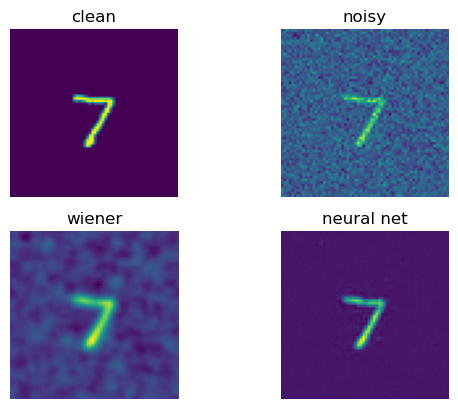

In [252]:
from skimage import restoration

# Wiener filter parameters
filt_len = 9
balance = 2  # regularization -- balances denoising vs preserving bandwidth
# set up an impulse PSF to operate Wiener as denoiser only, no deconvolution
psf = np.zeros([filt_len,filt_len])
psf[filt_len//2, filt_len//2] = 1.

x = next(iter(dataloader_val))[0] # get a batch of images
forwardModel = ForwardModel(0.2)
y = forwardModel(x)

# denoise with neural network
with torch.no_grad():
    xhat = net(y.to(device))

# denoise with Wiener filter
xhat_wiener = restoration.wiener(y[0].cpu().squeeze().numpy(),psf,balance)

# calculate MAE, MSE, Pearson, PSNR, SSIM metrics
x_np = x[0].cpu().numpy().squeeze()
xhat_np = xhat[0].cpu().numpy().squeeze()

MSE_neural = MSE(x_np,xhat_np)
MAE_neural = MAE(x_np,xhat_np)
pearson_neural = Pearson(x_np,xhat_np)
SSIM_neural = SSIM(x_np,xhat_np)
PSNR_neural = PSNR(x_np,xhat_np)

MSE_wiener = MSE(x_np, xhat_wiener)
MAE_wiener = MAE(x_np, xhat_wiener)
pearson_wiener = Pearson(x_np, xhat_wiener)
SSIM_wiener = SSIM(x_np, xhat_wiener)
PSNR_wiener = PSNR(x_np, xhat_wiener)

print('method \t MSE \t MAE \tPearson\t SSIM \t PSNR (dB)')
print(f'Neural \t {MSE_neural:0.3f} \t {MAE_neural:0.3f} \t {pearson_neural:0.3f} \t {SSIM_neural:0.3f} \t {PSNR_neural:0.3f}')
print(f'Wiener \t {MSE_wiener:0.3f} \t {MAE_wiener:0.3f} \t {pearson_wiener:0.3f} \t {SSIM_wiener:0.3f} \t {PSNR_wiener:0.3f}')

# plot results
plt.subplot(221)
plt.imshow(x[0].cpu().squeeze())
plt.axis('off')
plt.title('clean')
plt.subplot(222)
plt.imshow(y[0].cpu().squeeze())
plt.axis('off')
plt.title('noisy')
plt.subplot(223)
plt.imshow(xhat_wiener)
plt.axis('off')
plt.title('wiener')
plt.subplot(224)
plt.imshow(xhat[0].cpu().squeeze())
plt.axis('off')
plt.title('neural net')
plt.show()

In [220]:
print('a\tb\tc')

a	b	c


# Uncertainty quantification

In [157]:
# CNN neural network with uncertainty
class CNN_uncert( nn.Module ):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32,2,kernel_size=3,padding=1) )

        # initialize
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                nn.init.constant_(m.bias,0)
    

    def forward(self, x):
        out = self.net(x)
        xhat = out[:,0]
        variance = F.softplus(out[:,1])
        return xhat, variance
    
net = CNN_uncert()
net = net.to(device)


In [392]:
# define a simple u-net with batchnorm and variance estimate
class UNet_uncert( nn.Module ):
    def __init__(self):
        super().__init__()
        
        self.downconv1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))
        self.downconv2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))
        self.downconv3 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))
        self.downconv4 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1),nn.BatchNorm2d(32))

        self.upconv1 = nn.Sequential(
                    nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                    nn.BatchNorm2d(32) )
        self.upconv2 = nn.Sequential(
                    nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                    nn.BatchNorm2d(32) )
        self.upconv3 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                        nn.BatchNorm2d(32) )
        self.upconv4 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1, stride=2, output_padding=1),
                        nn.BatchNorm2d(32) )

        self.outconv_a = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 3, padding=1)
        self.outconv_b = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 3, padding=1)

    def forward(self, x):
        featdown1 = F.leaky_relu(self.downconv1(x))
        featdown2 = F.leaky_relu(self.downconv2(F.max_pool2d(featdown1,2)))
        featdown3 = F.leaky_relu(self.downconv3(F.max_pool2d(featdown2,2)))
        featdown4 = F.leaky_relu(self.downconv4(F.max_pool2d(featdown3,2)))

        featup1 = F.leaky_relu(self.upconv1(F.max_pool2d(featdown4,2)))
        skip1 = torch.cat((featdown4, featup1),1)
        featup2 = F.leaky_relu(self.upconv2(skip1))
        skip2 = torch.cat((featdown3, featup2),1)
        featup3 = F.leaky_relu(self.upconv3(skip2))
        skip3 = torch.cat((featdown2, featup3),1)
        featup4 = F.leaky_relu(self.upconv4(skip3))
        skip4 = torch.cat((featdown1, featup4),1)
        xhat = self.outconv_a(skip4)
        var = F.softplus(self.outconv_b(skip4))

        return xhat, var
        
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.)

net = UNet_uncert().to(device)
net.apply(init_weights)

UNet_uncert(
  (downconv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downconv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downconv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downconv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upconv1): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running

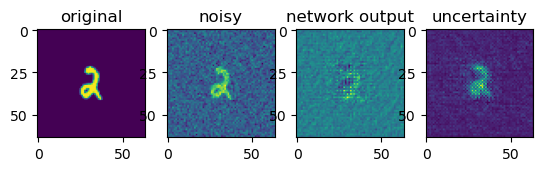

In [316]:
# test run a noisy image through the network
x = next(iter(dataloader_train))[0] # get a batch of images
forwardModel = ForwardModel(0.2)
y = forwardModel(x)
with torch.no_grad():
    xhat, var = net(y.to(device)) # run through network

plt.subplot(141)
plt.imshow(x[0].squeeze())
plt.title('original')
plt.subplot(142)
plt.imshow(y[0].squeeze())
plt.title('noisy')
plt.subplot(143)
plt.imshow(xhat[0].cpu().squeeze())
plt.title('network output')
plt.subplot(144)
plt.imshow(var[0].cpu().squeeze())
plt.title('uncertainty')
plt.show()


In [318]:
# heteroscedastic loss function
class HeteroscedasticLoss( nn.Module ):
    def __init__(self):
        super().__init__()
        self.eps=1e-5

    def forward(self, mean, var, target):
        var += self.eps
        loss = 0.5*torch.mean( torch.abs(mean - target)/var + torch.log(var))
        return loss

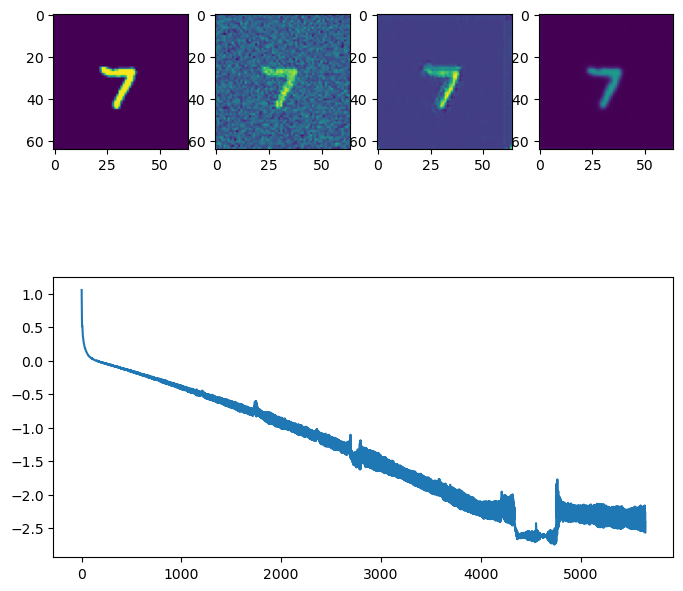

KeyboardInterrupt: 

In [394]:
# supervised training
forwardModel = ForwardModel(0.2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn_het = HeteroscedasticLoss()
loss_fn_L2 = nn.L1Loss()
het_loss_warmup_iters = 4000

loss_train_vec = []

# training loop
n_epochs = 100
i_iter = 0
for epoch in range(1,n_epochs):
    for data, label in dataloader_train:
    
        x = data.to(device)
        y = forwardModel(x)
        xhat,var = net(y)

        # compare recovered image with measurement
        loss_het = loss_fn_het(xhat,var,x)
        loss_L2 = loss_fn_L2(xhat,x)
        alpha=0
        alpha = i_iter / het_loss_warmup_iters
        if alpha > 1:
            alpha = 1
        
        loss = alpha * loss_het + (1-alpha)*loss_L2
        
        optimizer.zero_grad()

        loss.backward()
        nn.utils.clip_grad_norm(net.parameters(),0.01)
        optimizer.step()
    
        loss_train_vec += [loss.item()]
        i_iter += 1
    
        # plot training/validation loss curves
        if (i_iter+1) % 10 == 0:
            clear_output(wait=True)
            plt.figure(figsize=[8,8])
            plt.subplot(241)
            plt.imshow(x[0].cpu().squeeze())
            plt.subplot(242)
            plt.imshow(y[0].cpu().squeeze())
            plt.subplot(243)
            plt.imshow(xhat[0].detach().cpu().squeeze())
            plt.subplot(244)
            plt.imshow(var[0].detach().cpu().squeeze(),vmin=0,vmax=1)
            plt.subplot(212)
            plt.plot(loss_train_vec)
            plt.show()
    

In [118]:
# check if uncertainty increases with noise level
# render a panel of images
noiseLevels = [0.1, 0.2, 0.4, 0.6, 0.8]
plt.figure(figsize=[4,7])
for ind in range(5):
    x = next(iter(dataloader_val))[0] # get a batch of images
    forwardModel = ForwardModel(noiseLevels[ind])
    y = forwardModel(x)
    with torch.no_grad():
        xhat,var = net(y.to(device))
        
    plt.subplot(5,4,ind*4+1)
    plt.imshow(x[ind].squeeze())
    plt.axis('off')
    if ind==0:
        plt.title('original')
    plt.subplot(5,4,ind*4+2)
    plt.imshow(y[ind].squeeze())
    plt.axis('off')
    if ind==0:
        plt.title('noisy')
    plt.subplot(5,4,ind*4+3)
    plt.imshow(xhat[ind].cpu().squeeze())
    plt.axis('off')
    if ind==0:
        plt.title('denoised')
    plt.subplot(5,4,ind*4+4)
    plt.imshow(var[ind].cpu().squeeze(),vmin=0,vmax=2)
    plt.axis('off')
    if ind==0:
        plt.title('variance')
plt.show()

NameError: name 'dataloader_val' is not defined

<Figure size 400x700 with 0 Axes>

# Unsupervised Learning (noise2void)

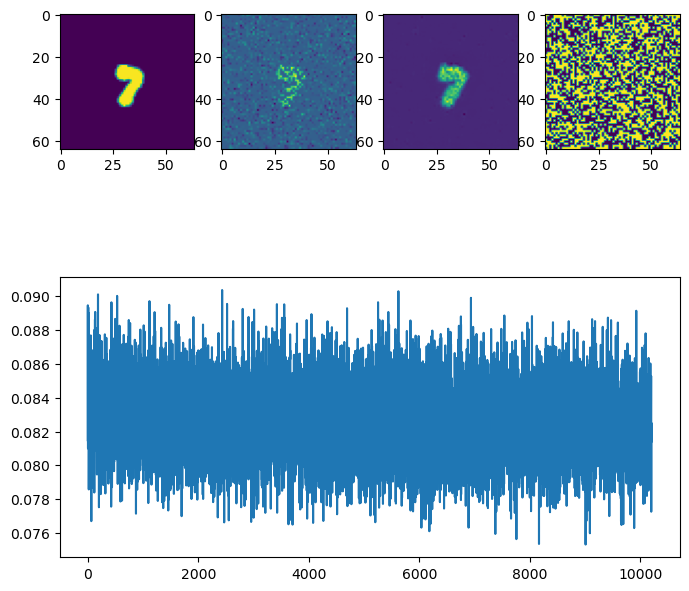

KeyboardInterrupt: 

In [259]:
# unsupervised training (noise2void)
#optimizer = torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_fn = nn.L1Loss()

loss_train_vec = []

# training loop
n_epochs = 100000
for epoch in range(1,n_epochs):
    ind = randint(0,len(dataset_train)-1)
    x = dataset_train[ind][0].to(device)

    
    y = forwardModel(x)
    
    # noise2void masking: select 10% of pixels for noise2void loss
    mask = torch.rand_like(y) > 0.5
    y_masked = y.clone() # use clone operation; otherwise, modifications to y_masked will overwrite data in y
    y_masked[mask] = 0.
    
    xhat = net(y_masked.unsqueeze(0))

    # compare recovered image with measurement
    #loss = loss_fn(xhat.flatten()[mask.flatten()],y.flatten()[mask.flatten()])
    loss = loss_fn(xhat*mask,y*mask)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    loss_train_vec += [loss.item()]
    
    # plot training/validation loss curves
    if (epoch+1) % 200 == 0:
        clear_output(wait=True)
        plt.figure(figsize=[8,8])
        plt.subplot(241)
        plt.imshow(x.cpu().squeeze())
        plt.subplot(242)
        plt.imshow(y_masked.cpu().squeeze())
        plt.subplot(243)
        plt.imshow(xhat.detach().cpu().squeeze())
        plt.subplot(244)
        plt.imshow(mask.cpu().squeeze())
        plt.subplot(212)
        plt.plot(loss_train_vec)
        plt.show()
    

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

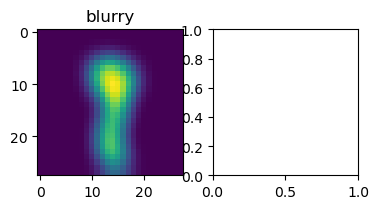

In [19]:
ind = randint(0,(len(y)-1))
plt.subplot(131)
plt.imshow(x_val[ind].cpu().squeeze())
plt.title('blurry')
plt.subplot(132)
plt.imshow(yhat[ind].cpu().squeeze())
plt.title('estimate')
plt.subplot(133)
plt.imshow(y[ind].cpu().squeeze())
plt.title('ground truth')
plt.show()

# Try a different dataset
[Link to PolyU Real World Noisy Images Dataset](https://github.com/csjunxu/PolyU-Real-World-Noisy-Images-Dataset)

In [9]:
# download dataset
import os
import urllib.request
import zipfile
url = "https://github.com/csjunxu/PolyU-Real-World-Noisy-Images-Dataset/archive/refs/heads/master.zip"

file_path="polyu.zip"
if not os.path.exists(file_path):
    urllib.request.urlretrieve(url,file_path)

extract_to = "polyu"
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

    with zipfile.ZipFile(file_path,'r') as zip_ref:
        zip_ref.extractall(extract_to)

PolyU dataset loaded with n=100 images


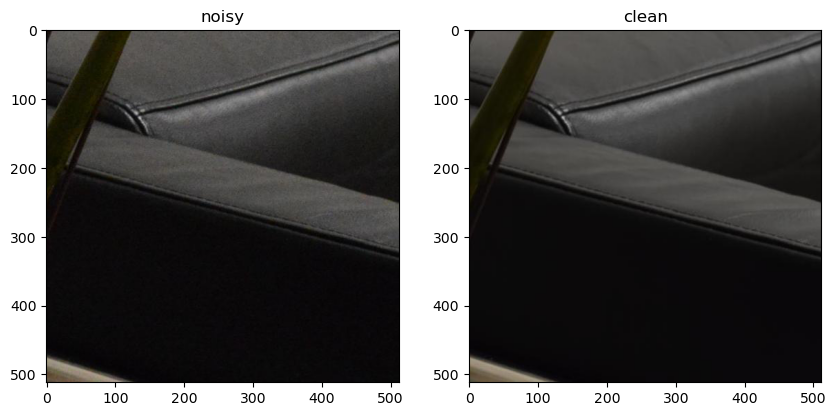

In [115]:
# set up a data class
# data files are of the form prefix_mean.jpg, prefix_real.jpg
# where the _real.jpg is the noisy image and _mean.jpg is the clean reference
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt

data_path = "polyu/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages"

class PolyUDataset( Dataset ):
    def __init__(self, data_path, transform=None):
        super().__init__()

        # get a listing of all the files
        self.data_path = data_path
        self.transform = transform
        listing = sorted(os.listdir(data_path))
        self.files_noisy = [f for f in listing if f.endswith("_real.JPG")]
        self.files_clean = [f for f in listing if f.endswith("_mean.JPG")]

    def __len__(self):
        return len(self.files_noisy)

    def __getitem__(self, ind):
        filename_x = self.files_noisy[ind]
        x = Image.open(os.path.join(self.data_path,filename_x))

        filename_y = self.files_clean[ind]
        y = Image.open(os.path.join(self.data_path,filename_y))

        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        
        return x, y

transform = transforms.Compose([transforms.ToTensor()])
dataset_polyu = PolyUDataset(data_path, transform)

n = len(dataset_polyu)
print(f"PolyU dataset loaded with n={n} images")

batch_size=16
dataloader_polyu = DataLoader(dataset_polyu, batch_size, shuffle=True)

data = next(iter(dataloader_polyu))
x = data[0]
y = data[1]

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(x[0].cpu().squeeze().permute(1,2,0))
plt.title('noisy')
plt.subplot(122)
plt.imshow(y[0].cpu().squeeze().permute(1,2,0))
plt.title('clean')
plt.show()
